# Investigating Climate Impacts examples - code examples

In [51]:
import pathlib
import datetime
import calendar

In [7]:
import pandas

In [8]:
import matplotlib
import matplotlib.pyplot

In [18]:
data_root_dir = '/data/users/shaddad/impact_lab/using_climate_data/5Sites/DataFramesAll'

In [142]:
site_plot_colours = {'cambridge': 'red', 'exeter': 'orange', 'manchester': 'green', 'newcastle': 'blue', 'edinburgh': 'purple'}
site_list = list(site_plot_colours.keys())
var_list = ['rss', 'sfcWind', 'tasmax', 'tasmin']
era_range_list = {'era1': (1981,2000),
                  'era2': (2021, 2040),
                  'era3': (2061, 2080),
                 }
data_type = 'ensm' # abbreviation of ensemble mean
[calendar.month_name[ix1] for ix1 in range(1,13)]=

In [20]:
fname_template = '{var}_{site}_ensm_{era}.csv'

In [83]:
ensm_datasets = {}

From the very large set of data from UKCP, we have selected some variables and extracted ensemble means of daily averages for each day of the year at certain sites of interest (which we have chosen for this demo).

In [108]:
for site in site_list:
    for var in var_list:
        for era_name, era_range in era_range_list.items():
            df1 = pandas.read_csv(pathlib.Path(data_root_dir) / fname_template.format(var=var,
                                                          site=site,
                                                          era=era_name,
                                                         ))
            df1['month'] = (((df1.index // 30) - 1) % 12) +1
            df1['season'] = (df1.index // 30) // 3
            ensm_datasets[(site,var,era_name)] = df1.drop('Unnamed: 0',axis=1)
            

Plot changes in annual solar radiation per day at each of the 5 sites to see how this will change due to projected changes in climate

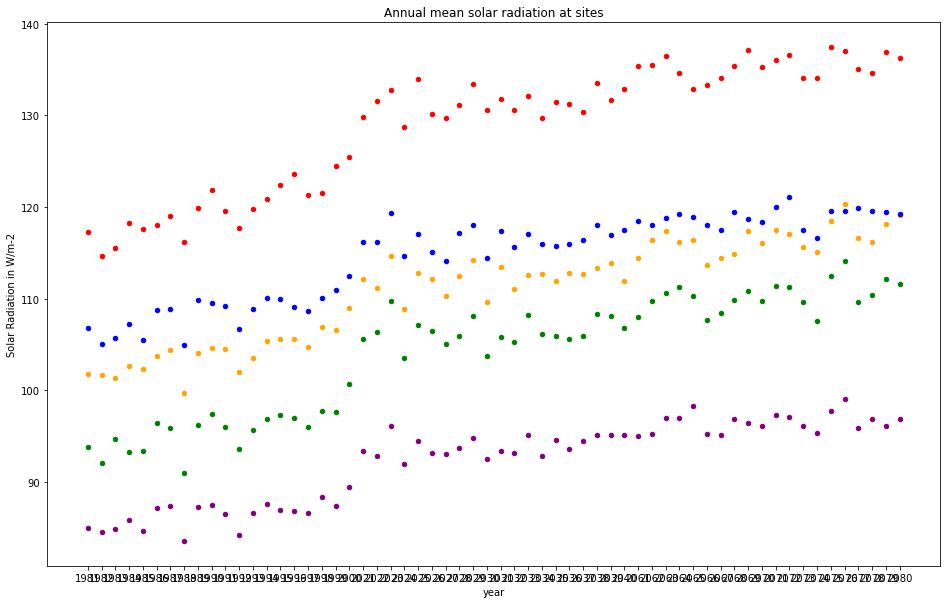

In [156]:
rss_annual_means = pandas.DataFrame(
    {site: pandas.concat([ensm_datasets[site,'rss',era_name].drop(['month','season'],axis=1).transpose().mean(axis=1) for era_name in era_range_list.keys()])
 for site in site_list}
)
rss_annual_means['year'] = rss_annual_means.index
fig_annual_mean_rss = matplotlib.pyplot.figure(f'rss_annual_mean', figsize=(16,10))
ax_annual_mean_rss = fig_annual_mean_rss.add_subplot(1,1,1, title='Annual mean solar radiation at sites')
for site in site_list:
    rss_annual_means.plot.scatter(x='year', y=site, c=site_plot_colours[site], ax=ax_annual_mean_rss, xlabel='solar')
_ = ax_annual_mean_rss.set_ylabel('Solar Radiation in W/m-2')

In [177]:
monthly_averages_exeter = pandas.DataFrame({era_name: ensm_datasets['exeter','rss',era_name].groupby('month').mean().mean(axis=1) for era_name in era_range_list.keys()})
monthly_averages_exeter['month_name'] = [calendar.month_name[ix1] for ix1 in monthly_averages_exeter.index]

<AxesSubplot:title={'center':'Changes in solar radiation for Exeter'}, xlabel='month_name'>

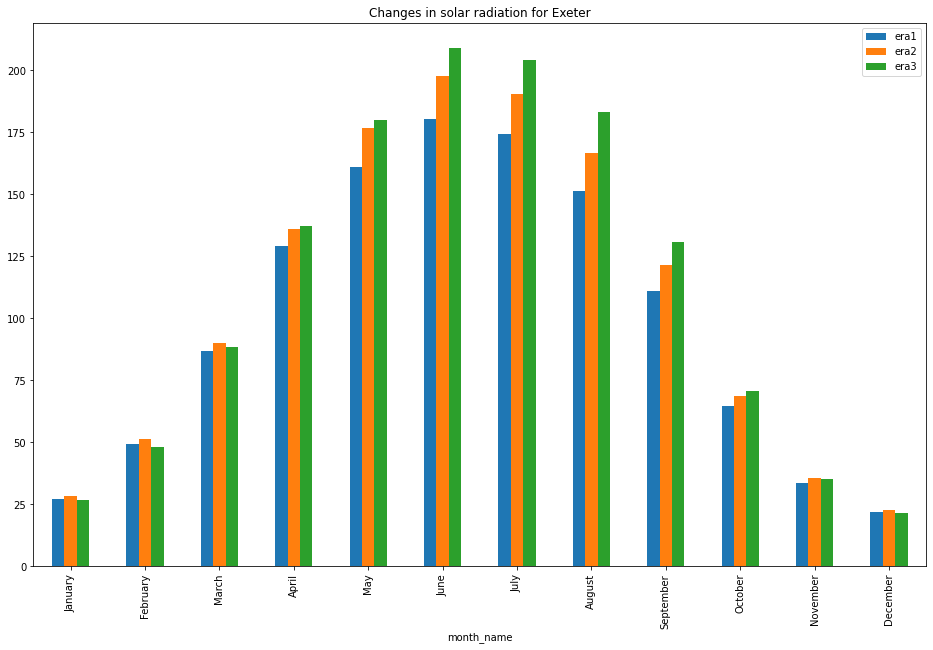

In [180]:
monthly_averages_exeter.plot.bar(x='month_name', figsize=(16,10), title='Changes in solar radiation for Exeter')

## Energy generation



### Solar generation - solar radiation

In [ ]:
# load ukcp solar radiation

In [1]:
# select a site (interactively?)

In [2]:
# create a time series for this location (for each of three eras, 1 per ensemble member)

In [ ]:
# show cange in solar radiation

In [ ]:
# show comparison for 3 sites (SW england, N England, scotland)

### Wind generation - surface wind speed

### Heat waves - health and recreation

holiday related small businesses, how is this affected by temperatures?
higher nighttime temperaturesd also affect leisure sites

impacts on health from min and max temperatures in heat waves - maybe affect the need for cooling in office, or ability to do outdoor work during the day?